# 1. Calculate Theis (1941)-Glover and Balmer (1954) analytical solution:

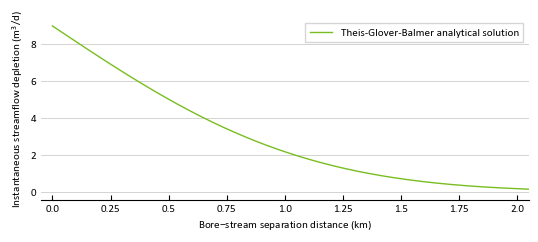

In [74]:
%matplotlib inline

#%% Import packages
import sys
sys.path.append('..')
import flopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import erfc, sqrt

#%% Define instantaneous Theis-Glover-Balmer analytical solution
def Theis1941GloverBalmer1954(Qw, R, t, S, T):
    D = []    
    for r in R:
        try:
            D.append(erfc(sqrt(((r**2.)*S)/(4.*T*t))))
        except:
            D.append(0.)
    return Qw*np.array(D)

#%% Define Matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif' ] = 'Calibri'
mpl.rcParams['font.size'       ] = 8
mpl.rcParams['mathtext.default'] = 'regular'          
mpl.rcParams['xtick.direction' ] = 'in'
mpl.rcParams['ytick.direction' ] = 'in'       
mpl.rcParams['lines.linewidth' ] = 0.5      

#%% Define plot colours
c = np.array([(120., 190.,  32.), 
              (  0.,  75., 135.), 
              (255., 184.,  28.),
              ( 65., 182., 230.),
              (228.,   0.,  43.),
              (232., 119.,  34.),
              (255., 229., 177.)])/255.

#%% Define global parameters
FWDmodelname         = '01_Instantaneous_depletion_TGB_FWD'
ADJmodelname         = '01_Instantaneous_depletion_TGB_ADJ'
totim                = 365.
nlay, nrow, ncol     = 1, 100, 100
delr, delc, top, bot = 25., 25., 20., 0. # NOTE: 20 m thick, not 50 m
thk                  = top-bot
hk, vka, ss, sy      = 1.0, np.nan, np.nan, 0.02
tran                 = hk*thk
Kr, Br               = hk, 1.0
Lr, Wr               = delr, delc
stg, rbt, rcol       = top-5., bot, 0
rrows                = np.arange(nrow)
#cnd                  = Kr*Wr*Lr/Br*0.51
cnd                  = Kr*Wr*Lr/Br
wrow, wflx           = nrow/2, -9. 
gamma, beta          = 1000., top
wcols                = range(0, ncol, 10) #range(ncol)[:7]

#%% Create output figure
f,s = plt.subplots(1,1, figsize=[16.00/2.54, 6.00/2.54])

#%% Calculate and plot Theis-Glover-Balmer analytical solution
x = np.arange(ncol*delr)
s.plot(x, Theis1941GloverBalmer1954(abs(wflx), x, totim, sy, tran),
       '-', c=list(c[0]), lw=1.0, label='Theis-Glover-Balmer analytical solution')

s.legend(numpoints=1, ncol=1, labelspacing=0.75, fancybox=False, fontsize=8)
s.set_xlim(-50, 2050)
s.set_xticklabels(s.get_xticks()/1000.)
s.set_xlabel('Bore$-$stream separation distance (km)')
s.set_ylabel('Instantaneous streamflow depletion (m$^{3}$/d)')
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')

for side in ['top', 'left', 'right']:
    s.spines[side].set_visible(False)
    s.yaxis.set_ticks_position('none')
    s.grid(which='major', axis='y', 
           c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)
f

# 2. Run multiple numerical forward models:

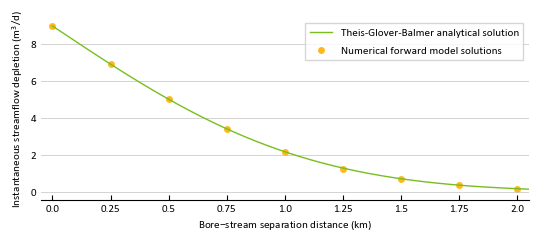

In [75]:
#%% Run zero extraction forward model
nper, perlen, nstp, stflag = 1, totim, int(totim), False
mf = flopy.modflow.Modflow(modelname=FWDmodelname, exe_name='../mf2005.exe')

dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                               delr=delr, delc=delc, top=top, botm=bot, 
                               steady=stflag, perlen=perlen, nstp=nstp)

ibound = np.ones([nlay, nrow, ncol], dtype=int)
strt = top*np.ones([nlay, nrow, ncol], dtype=float)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

bcf = flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 

spd = {}
lst = []
for rrow in rrows:
    lst.append([0, rrow, rcol, stg, cnd, rbt])
spd.update({0: lst})
riv = flopy.modflow.ModflowRiv(mf, ipakcb=1, stress_period_data=spd) 

pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)

spd = {(nper-1, nstp-1): ['print head', 'save head', 'save budget']}
oc  = flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    
mf.write_input()
success, buff = mf.run_model(silent=True)

flx = flopy.utils.binaryfile.CellBudgetFile(FWDmodelname+'.cbc')
flx = flx.get_data(text='   RIVER LEAKAGE', full3D=True)
flx = np.array(flx)[-1,:,:,:]
QRwp1 = np.ones(len(wcols))*np.abs(np.sum(-flx[-1,rrows,rcol]))

#%% Run forward models for each bore-stream separation distance
nper, perlen, nstp, stflag = 1, totim, int(totim), False
QRwp2 = []
depl_FWD = []
wcs = range(ncol) 
x = np.arange(0, ncol)*delc
xw = x[wcols]
for i,wcol in enumerate(wcols):
    mf = flopy.modflow.Modflow(modelname=FWDmodelname, exe_name='../mf2005.exe')
    
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=top, botm=bot, 
                                   steady=stflag, perlen=perlen, nstp=nstp)
    
    ibound = np.ones([nlay, nrow, ncol], dtype=int)
    strt = top*np.ones([nlay, nrow, ncol], dtype=float)
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    
    bcf = flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 
    
    spd = {}
    lst = []
    for rrow in rrows:
        lst.append([0, rrow, rcol, stg, cnd, rbt])
    spd.update({0: lst})
    riv = flopy.modflow.ModflowRiv(mf, ipakcb=1, stress_period_data=spd) 
    
    pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)
    
    spd = {(nper-1, nstp-1): ['print head', 'save head', 'save budget']}
    oc  = flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    
    spd = {0: [[0, wrow, wcol, wflx]]}
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd)
    
    mf.write_input()
    success, buff = mf.run_model(silent=True)
    
    flx = flopy.utils.binaryfile.CellBudgetFile(FWDmodelname+'.cbc')
    flx = flx.get_data(text='   RIVER LEAKAGE', full3D=True)
    flx = np.array(flx)[-1,:,:,:]
    QRwp2.append(np.abs(np.sum(-flx[-1,rrows,rcol])))
    depl_FWD.append(QRwp1[i]-QRwp2[-1])
    if i==0:
        lab='Numerical forward model solutions'
    else:
        lab='_no_label'
    s.plot(xw[i], depl_FWD[-1], 'o', ms=5, mfc=list(c[2]), mec='none', 
           label=lab, zorder=0)       

QRwp2 = np.array(QRwp2)
depl_FWD = np.array(depl_FWD)

s.legend(numpoints=1, ncol=1, labelspacing=0.75, fancybox=False, fontsize=8)
f

# 3. Run a single numerical adjoint state model:

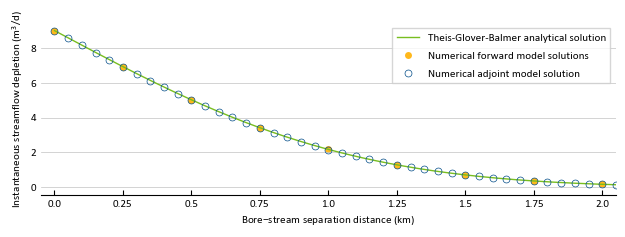

In [76]:
#%% Run single adjoint model
mf = flopy.modflow.Modflow(modelname=ADJmodelname, exe_name='../mf2005.exe')

nper, perlen, nstp, stflag = 1, totim, int(totim), False

dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                               delr=delr, delc=delc, top=top, botm=bot, 
                               steady=stflag, perlen=perlen, nstp=nstp)
                                
ibound = np.ones([nlay, nrow, ncol], dtype=int)
strt = beta*np.ones([nlay, nrow, ncol], dtype=float)
strt[0, rrows, rcol] = cnd/delr/delc/sy*gamma+beta
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

bcf = flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 

lst = []
for row in rrows:
    lst.append([0, row, rcol, beta, cnd, rbt])
spd = {0: lst}
riv = flopy.modflow.ModflowRiv(mf, stress_period_data=spd) 

pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)

spd = {}
for ts in range(nstp):
    spd.update( {(0, ts): ['print head', 'save head', 'save budget']})
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)
      
mf.write_input()
success, buff = mf.run_model(silent=True)

hds = flopy.utils.binaryfile.HeadFile(ADJmodelname+'.hds')
adj = hds.get_alldata()
adj = np.reshape(adj, [nstp, nrow, ncol])
adj = adj-beta
adj = adj/gamma
adjsum = adj.sum(axis=0)*abs(wflx)
hds.close()

x = np.arange(0, ncol)*delc
s.plot(x[::2], adjsum[wrow,:][::2], 'o', ms=5, mec=list(c[1]), mfc='none', 
       mew=0.5, label='Numerical adjoint model solution')

# Remove Modflow input and output files
from os import getcwd, listdir, remove
for fn in listdir(getcwd()):
    if fn[-3:] in ['bas', 'bcf', 'cbc', 'dis', 'hds', 'ist', 'nam', '.oc', 'pcg', 'riv', 'wel']:
        remove(fn)

#%% Apply plot formatting and finish
s.legend(numpoints=1, ncol=1, labelspacing=0.75, fancybox=False, fontsize=8)
s.set_xlim(-50, 2050)
s.set_xticklabels(s.get_xticks()/1000.)

f.tight_layout()
f.savefig('01_Instantaneous_depletion_TGB_vs_FWD_vs_ADJ_v01_141118.png', dpi=500 )
f